Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from fastprogress.fastprogress import progress_bar

Create Necessary Functions

In [ ]:
class Gelu(nn.Module):
    """Implements GELU as an activation Function """
    def __init__(self):
        super().__init__()
        self.gelu = nn.GELU()

    def forward(self, x):
        """Applies GELU Activation to input tensor"""
        return self.gelu(x)
    
class tanh(nn.Module):
    """Implements Tanh as an activation Function """
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()

    def forward(self, x):
        """Applies tanh Activation to input tensor"""
        return self.tanh(x)

class EarlyStopping:
    """Implements EarlyStopping Method to avoid overfitting and resource waste"""
    def __init__(self, patience=5000, min_delta=0.0):
        """
        Args:
            patience (int): Max. step number with no progress
            min_delta (float): Min. progress to update counter
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss

        elif self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def build_model(n_inputs, n_outputs, n_hlayers, n_neurons, act_func):
    """
    Creates fully connected NN with XAVIER inicialization.
    
    Args:
        n_inputs: Input layer Neurons
        n_outputs: Output Layer Neurons
        n_hlayers: Hidden Layers
        n_neurons: Neurons Per Hidden Layer
        act_func: Activation Function
    
    Returns:
        Fully connected NN
    """
    layers = []

    layers.append(nn.Linear(n_inputs, n_neurons))       # Input layer
    nn.init.xavier_uniform_(layers[-1].weight)  # Inicialización Xavier
    nn.init.zeros_(layers[-1].bias)
    layers.append(act_func())

    for _ in range(n_hlayers):                          # Hidden layer
        layers.append(nn.Linear(n_neurons, n_neurons))
        nn.init.xavier_uniform_(layers[-1].weight)  # Inicialización Xavier
        nn.init.zeros_(layers[-1].bias)
        layers.append(act_func())

    layers.append(nn.Linear(n_neurons, n_outputs))      # Output layer

    model = nn.Sequential(*layers)

    return model

def Grads(y, x, idx=None):
    """
    Computes the gradient of the input tensor.
    
    Args:
        y: Desired grads tensor
        x: Reference tensor to obtain grads
        idx: if none both grads are return, if 0 or 1 only one of them is return
        
    Returns:
        Grads in the desired axis"""
    outputs = torch.ones_like(y)
    grads, = torch.autograd.grad(y, 
                                 x, 
                                 grad_outputs=outputs, 
                                 create_graph=True)
    
    return grads if idx is None else grads[:, idx]

def sample(xmin, xmax, ymin, ymax , n_sample, device='cuda'):
    """Function to sample a given 2D domain enclosed in the max and min values.
    
    Args:
        xmin: Min x value of the domain
        xmax: Max x value of the domain
        ymin: Min y value of the domain
        ymax: Max y value of the domain
        n_sample: Number of points to sample
        device='cuda': Device to create the tensor in
    
    Returns:
        Sampled (n_sample,2) tensor in specified device
    """
    x = xmin + (xmax - xmin) * torch.rand(n_sample, device=device)
    y = ymin + (ymax - ymin) * torch.rand(n_sample, device=device)
    return torch.stack([x, y], dim=-1)

def bound_sample(xmin, xmax, ymin, ymax, b_sample, device='cuda'):
    """Function to sample a given 2D domain boundaries.
    
    Args:
        xmin: Min x value of the domain
        xmax: Max x value of the domain
        ymin: Min y value of the domain
        ymax: Max y value of the domain
        b_sample: Number of points to sample in EACH boundary
        device='cuda': Device to create the tensor in
    
    Returns:
        lbound: (b_sample, 2) tensor for the left boundary
        rbound: (b_sample, 2) tensor for the right boundary
        bbound: (b_sample, 2) tensor for the bottom boundary
        tbound: (b_sample, 2) tensor for the top boundary
    """
    y_left = ymin + (ymax - ymin) * torch.rand(b_sample, device=device)
    x_left = torch.full((b_sample,), xmin, device=device)
    lbound = torch.stack([x_left, y_left], dim=-1)

    y_right = ymin + (ymax - ymin) * torch.rand(b_sample, device=device)
    x_right = torch.full((b_sample,), xmax, device=device)
    rbound = torch.stack([x_right, y_right], dim=-1)

    x_bottom = xmin + (xmax - xmin) * torch.rand(b_sample, device=device)
    y_bottom = torch.full((b_sample,), ymin, device=device)
    bbound = torch.stack([x_bottom, y_bottom], dim=-1)

    x_top = xmin + (xmax - xmin) * torch.rand(b_sample, device=device)
    y_top = torch.full((b_sample,), ymax, device=device)
    tbound = torch.stack([x_top, y_top], dim=-1)

    return lbound, rbound, bbound, tbound

def run_model(model_run, b_sample, domain_size_x, domain_size_y, device='cuda'):
    """Runs trained model.
    
    Args:
        model_run: Trained Model to use for prediction
        b_sample: Number of samples for the prediction grid
        domain_size_x: X size of the domain
        domain_size_y: Y size of the domain
        device='cuda'

    Returns:
        Predicted u, v, p values as a (b_sample, b_sample) tensor in "device"    
    """
    x = np.linspace(0, domain_size_x, b_sample)
    y = np.linspace(0 , domain_size_y, b_sample)
    X = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
    X = torch.from_numpy(X).float().to(device=device)
    X.requires_grad_(True)

    model_run.eval()
    pred = model_run(X)  

    V_pred = Grads(pred[:,0], X)
    v, u = -V_pred[:,0], V_pred[:,1]

    p = pred[:,1]

    return u.reshape(b_sample, b_sample), v.reshape(b_sample, b_sample), p.reshape(b_sample,b_sample), x, y


Parameters Definition

In [3]:
domain_size_x = 4
domain_size_y = 2
n_sample = 15000
f_sample = 0
b_sample = 7500

# Physical
Uinf = 1
pinf = 101325
chord = 0.5
r0 = 1
din_vis = 5e-3
Re = Uinf*r0*chord/din_vis

print(Re)
din_p = 0.5*r0*Uinf**2 

# Model
n_inputs, n_outputs, n_hlayers, n_neurons, act_func = 2, 2, 4, 20, Gelu
device = torch.device('cuda')
af_model = build_model(n_inputs, n_outputs, n_hlayers, n_neurons, act_func)
af_model.to(device)

n_steps = 15000
optimizer = torch.optim.Adam(af_model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

100.0


Domain Sampling

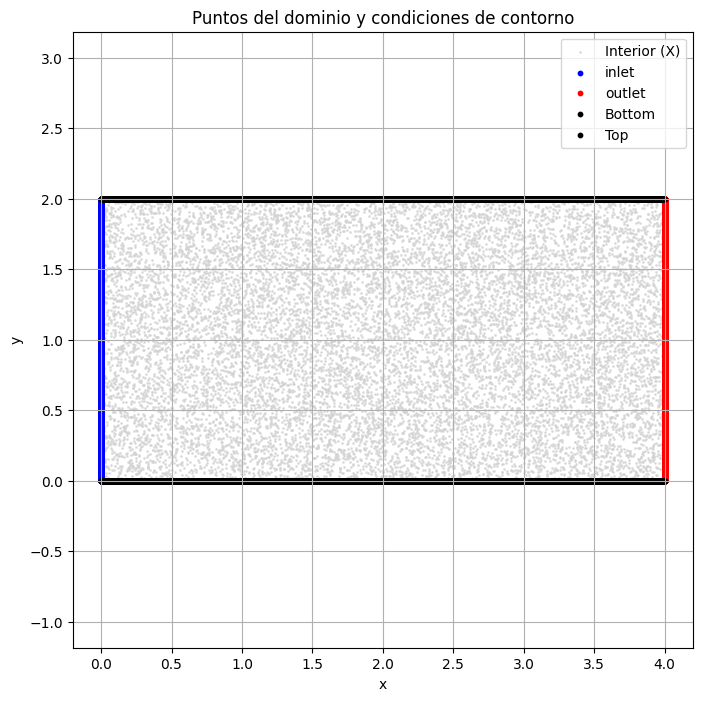

In [4]:
inlet, outlet, bot_wall, top_wall = bound_sample(0, domain_size_x, 0, domain_size_y, b_sample, device=device)

X = sample(0, domain_size_x, 0, domain_size_y,  n_sample, device=device)


# Prepare for plot
X_cpu = X.detach().cpu()
inlet1 = inlet
outlet1 = outlet
bot_bound = bot_wall
top_bound = top_wall
inlet_cpu = inlet1.detach().cpu()
outlet_cpu = outlet1.detach().cpu()
bot_cpu = bot_bound.detach().cpu()
top_cpu = top_bound.detach().cpu()

# Crear el plot
plt.figure(figsize=(8, 8))

# Dominio
plt.scatter(X_cpu[:, 0], X_cpu[:, 1], s=1, alpha=0.7, label='Interior (X)', color='lightgray')

# Fronteras
plt.scatter(inlet_cpu[:, 0], inlet_cpu[:, 1], s=10, label='inlet', color='blue')
plt.scatter(outlet_cpu[:, 0], outlet_cpu[:, 1], s=10, label='outlet', color='red')
plt.scatter(bot_cpu[:, 0], bot_cpu[:, 1], s=10, label='Bottom', color='black')
plt.scatter(top_cpu[:, 0], top_cpu[:, 1], s=10, label='Top', color='black')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos del dominio y condiciones de contorno')
plt.axis('equal')
plt.grid(True)
plt.show()

Model Training for each U_inf Option:  
    Adam -> LBFGS -> Prediction + Result save

In [5]:
Uinf_options = [1, 3, 5, 10]

u_list, v_list, p_list = [], [], []

for Uinf in Uinf_options:
    af_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 200, threshold=1e-2, min_lr=1e-7)
    af_early_stopper = EarlyStopping(patience=500, min_delta=1e-3)

    af_model.train()

    af_mb = progress_bar(range(1, n_steps+1))

    af_losses = []
    af_ns_losses = []
    af_uv_losses = []
    af_p_losses = []
    af_lr_list = []
    airf_loss = []

    alpha = 2

    X.requires_grad = True
    inlet.requires_grad=True
    outlet.requires_grad=True
    bot_wall.requires_grad=True
    top_wall.requires_grad=True

    for step in af_mb:
        delta = af_model(X)
        V1, p = delta[:,0], delta[:,1]

        grads = Grads(V1, X)
        v, u = -grads[:,0], grads[:,1]

        grads = Grads(u, X)
        u_x, u_y = grads[:, 0], grads[:, 1]

        grads = Grads(v, X)
        v_x, v_y = grads[:, 0], grads[:, 1]

        grads = Grads(p, X)
        p_x, p_y = grads[:, 0], grads[:, 1]

        u_xx = Grads(u_x, X, 0)
        u_yy = Grads(u_y, X, 1)
        v_xx = Grads(v_x, X, 0)
        v_yy = Grads(v_y, X, 1)

        ns_loss = criterion(r0*(u*u_x + v*u_y) + p_x - din_vis*(u_xx + u_yy), torch.zeros_like(u, device=device)) +\
                criterion(r0*(u*v_x + v*v_y) + p_y - din_vis*(v_xx + v_yy), torch.zeros_like(u, device=device))

        # Boundary Conditions    
        # Inlet
        in_pred = af_model(inlet)
        grads = Grads(in_pred[:,0], inlet)
        in_v, in_u = -grads[:,0], grads[:,1]

        inlet_cond = torch.stack([
            Uinf * torch.ones_like(inlet[:,0], device=device),
            torch.zeros_like(inlet[:,0], device=device),
        ], axis=-1)

        inlet_uv_loss = criterion(in_u, inlet_cond[:,0]) + criterion(in_v, inlet_cond[:,1])

        
        # Outlet
        out_pred = af_model(outlet)
        out_p = out_pred[:,1]

        outlet_p_loss = criterion(out_p, torch.zeros_like(out_p, device=device))
        

        # Bot boundary
        bot_pred = af_model(bot_wall)
        grads = Grads(bot_pred[:,0], bot_wall)
        bot_v, bot_u = -grads[:,0], grads[:,1]

        bot_bound_cond = torch.stack([
            torch.zeros_like(bot_wall[:,0], device=device),
            torch.zeros_like(bot_wall[:,0], device=device),
        ], axis=-1)

        bot_uv_loss = criterion(bot_u, bot_bound_cond[:,0]) + criterion(bot_v, bot_bound_cond[:,1])

        # Top boundary
        top_pred = af_model(top_wall)
        grads = Grads(top_pred[:,0], top_wall)
        top_v, top_u = -grads[:,0], grads[:,1]

        top_bound_cond = torch.stack([
            torch.zeros_like(top_wall[:,0], device=device),
            torch.zeros_like(top_wall[:,0], device=device),
        ], axis=-1)

        top_uv_loss = criterion(top_u, top_bound_cond[:,0]) + criterion(top_v, top_bound_cond[:,1])

        uv_loss = inlet_uv_loss + top_uv_loss + bot_uv_loss 
        p_loss = outlet_p_loss
        bound_loss = uv_loss + p_loss

        if (step%250 == 0) and (alpha > 1):
            alpha -= 0.1
        
        bound_loss *= alpha
        # Update
        optimizer.zero_grad()
        af_loss = (ns_loss + bound_loss)
        af_loss.backward()
        optimizer.step()
        af_scheduler.step(af_loss)


        af_lr = optimizer.param_groups[0]['lr']
        af_losses.append(af_loss.item())
        af_ns_losses.append(ns_loss.item())
        af_uv_losses.append(uv_loss.item())
        af_p_losses.append(p_loss.item())
        af_lr_list.append(af_lr)

        
        af_early_stopper(af_loss.item())
        if af_early_stopper.early_stop:
            print(f"Early stopping at step {step}")
            break
        #   airfoil_loss {10*airfoil_loss.item():.5f}  |
        af_mb.comment = f'loss {af_loss.item():.5f}  |  ns_loss {ns_loss.item():.5f}  |  bound_loss {bound_loss.item():.5f}  |  inlet {inlet_uv_loss.item():.5f}  |  top {top_uv_loss.item():.5f}  |  bot {bot_uv_loss.item():.5f}  |  learning_rate {af_lr:.3e}'
    

    X.requires_grad = True
    inlet.requires_grad = True
    outlet.requires_grad = True
    bot_wall.requires_grad = True
    top_wall.requires_grad = True

    patience = 25
    acc = 1e-3

    counter = 0

    def closure():
        af_optimizer.zero_grad()

        delta = af_model(X)
        V1, p = delta[:,0], delta[:,1]

        grads = Grads(V1, X)
        v, u = -grads[:,0], grads[:,1]

        grads = Grads(u, X)
        u_x, u_y = grads[:, 0], grads[:, 1]

        grads = Grads(v, X)
        v_x, v_y = grads[:, 0], grads[:, 1]

        grads = Grads(p, X)
        p_x, p_y = grads[:, 0], grads[:, 1]

        u_xx = Grads(u_x, X, 0)
        u_yy = Grads(u_y, X, 1)
        v_xx = Grads(v_x, X, 0)
        v_yy = Grads(v_y, X, 1)

        ns_loss = criterion(r0*(u*u_x + v*u_y) + p_x - din_vis*(u_xx + u_yy), torch.zeros_like(u, device=device)) +\
                criterion(r0*(u*v_x + v*v_y) + p_y - din_vis*(v_xx + v_yy), torch.zeros_like(u, device=device))

        # Boundary Conditions    
        # Inlet
        in_pred = af_model(inlet)
        grads = Grads(in_pred[:,0], inlet)
        in_v, in_u = -grads[:,0], grads[:,1]

        inlet_cond = torch.stack([
            Uinf * torch.ones_like(inlet[:,0], device=device),
            torch.zeros_like(inlet[:,0], device=device),
        ], axis=-1)

        inlet_uv_loss = criterion(in_u, inlet_cond[:,0]) + criterion(in_v, inlet_cond[:,1])

        
        # Outlet
        out_pred = af_model(outlet)
        out_p = out_pred[:,1]

        outlet_p_loss = criterion(out_p, torch.zeros_like(out_p, device=device))
        

        # Bot boundary
        bot_pred = af_model(bot_wall)
        grads = Grads(bot_pred[:,0], bot_wall)
        bot_v, bot_u = -grads[:,0], grads[:,1]

        bot_bound_cond = torch.stack([
            torch.zeros_like(bot_wall[:,0], device=device),
            torch.zeros_like(bot_wall[:,0], device=device),
        ], axis=-1)

        bot_uv_loss = criterion(bot_u, bot_bound_cond[:,0]) + criterion(bot_v, bot_bound_cond[:,1])

        # Top boundary
        top_pred = af_model(top_wall)
        grads = Grads(top_pred[:,0], top_wall)
        top_v, top_u = -grads[:,0], grads[:,1]

        top_bound_cond = torch.stack([
            torch.zeros_like(top_wall[:,0], device=device),
            torch.zeros_like(top_wall[:,0], device=device),
        ], axis=-1)

        top_uv_loss = criterion(top_u, top_bound_cond[:,0]) + criterion(top_v, top_bound_cond[:,1])

        uv_loss = inlet_uv_loss + top_uv_loss + bot_uv_loss 
        p_loss = outlet_p_loss
        bound_loss = uv_loss + p_loss

        # Update
        optimizer.zero_grad()
        loss = (ns_loss + bound_loss)

        loss = (ns_loss + bound_loss)
        
        loss.backward()

        return loss
            
    for lrate in [1]:
        best_loss = 1
        af_optimizer = torch.optim.LBFGS(
                    af_model.parameters(),
                    lr=lrate,
                    max_iter=500,
                    tolerance_grad=1e-7,
                    tolerance_change=1e-9,
                    history_size=100,
                    line_search_fn='strong_wolfe'
                    )
            
        for step in range(1, n_steps +1):
            loss_val = af_optimizer.step(closure)
            print(f"Step {step}, Loss = {loss_val.item():.6f}, learning_rate = {lrate:.3f}")
            
            if loss_val.item() < best_loss - acc:
                best_loss = loss_val.item()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping triggered.")
                    break


    u_pred, v_pred, p_pred, x, y = run_model(af_model, 500, domain_size_x, domain_size_y)
    mesh = np.meshgrid(x, y)
    mesh_points = len(x)

    u_pred = u_pred.detach().cpu().numpy()
    v_pred = v_pred.detach().cpu().numpy()
    p_pred = p_pred.detach().cpu().numpy()

    u_list.append(u_pred)
    v_list.append(v_pred)
    p_list.append(p_pred)

X, Y = np.meshgrid(x, y)  # (ny, nx)

# 2. Convertir el array 2D en una lista de puntos [(x0,y0), (x1,y1), ...]
points = np.vstack([X.ravel(), Y.ravel()]).T  # shape (N, 2)

Early stopping at step 3115
Step 1, Loss = 0.004932, learning_rate = 1.000
Step 2, Loss = 0.002613, learning_rate = 1.000
Step 3, Loss = 0.001494, learning_rate = 1.000
Step 4, Loss = 0.000978, learning_rate = 1.000
Step 5, Loss = 0.000744, learning_rate = 1.000
Step 6, Loss = 0.000605, learning_rate = 1.000
Step 7, Loss = 0.000507, learning_rate = 1.000
Step 8, Loss = 0.000436, learning_rate = 1.000
Step 9, Loss = 0.000360, learning_rate = 1.000
Step 10, Loss = 0.000306, learning_rate = 1.000
Step 11, Loss = 0.000272, learning_rate = 1.000
Step 12, Loss = 0.000227, learning_rate = 1.000
Step 13, Loss = 0.000219, learning_rate = 1.000
Step 14, Loss = 0.000219, learning_rate = 1.000
Step 15, Loss = 0.000219, learning_rate = 1.000
Step 16, Loss = 0.000219, learning_rate = 1.000
Step 17, Loss = 0.000219, learning_rate = 1.000
Step 18, Loss = 0.000219, learning_rate = 1.000
Step 19, Loss = 0.000219, learning_rate = 1.000
Step 20, Loss = 0.000219, learning_rate = 1.000
Step 21, Loss = 0.000

Early stopping at step 9028
Step 1, Loss = 0.036185, learning_rate = 1.000
Step 2, Loss = 0.026709, learning_rate = 1.000
Step 3, Loss = 0.021337, learning_rate = 1.000
Step 4, Loss = 0.016047, learning_rate = 1.000
Step 5, Loss = 0.012812, learning_rate = 1.000
Step 6, Loss = 0.010741, learning_rate = 1.000
Step 7, Loss = 0.009836, learning_rate = 1.000
Step 8, Loss = 0.009233, learning_rate = 1.000
Step 9, Loss = 0.008707, learning_rate = 1.000
Step 10, Loss = 0.008193, learning_rate = 1.000
Step 11, Loss = 0.007646, learning_rate = 1.000
Step 12, Loss = 0.007193, learning_rate = 1.000
Step 13, Loss = 0.006806, learning_rate = 1.000
Step 14, Loss = 0.006356, learning_rate = 1.000
Step 15, Loss = 0.005944, learning_rate = 1.000
Step 16, Loss = 0.005596, learning_rate = 1.000
Step 17, Loss = 0.005356, learning_rate = 1.000
Step 18, Loss = 0.005020, learning_rate = 1.000
Step 19, Loss = 0.004746, learning_rate = 1.000
Step 20, Loss = 0.004707, learning_rate = 1.000
Step 21, Loss = 0.004

Early stopping at step 5169
Step 1, Loss = 0.061231, learning_rate = 1.000
Step 2, Loss = 0.052657, learning_rate = 1.000
Step 3, Loss = 0.045807, learning_rate = 1.000
Step 4, Loss = 0.041032, learning_rate = 1.000
Step 5, Loss = 0.038032, learning_rate = 1.000
Step 6, Loss = 0.035219, learning_rate = 1.000
Step 7, Loss = 0.033395, learning_rate = 1.000
Step 8, Loss = 0.030925, learning_rate = 1.000
Step 9, Loss = 0.028861, learning_rate = 1.000
Step 10, Loss = 0.027200, learning_rate = 1.000
Step 11, Loss = 0.025961, learning_rate = 1.000
Step 12, Loss = 0.024871, learning_rate = 1.000
Step 13, Loss = 0.023936, learning_rate = 1.000
Step 14, Loss = 0.022991, learning_rate = 1.000
Step 15, Loss = 0.022087, learning_rate = 1.000
Step 16, Loss = 0.021397, learning_rate = 1.000
Step 17, Loss = 0.020900, learning_rate = 1.000
Step 18, Loss = 0.020430, learning_rate = 1.000
Step 19, Loss = 0.020017, learning_rate = 1.000
Step 20, Loss = 0.019576, learning_rate = 1.000
Step 21, Loss = 0.019

Early stopping at step 8368
Step 1, Loss = 0.143104, learning_rate = 1.000
Step 2, Loss = 0.143104, learning_rate = 1.000
Step 3, Loss = 0.143104, learning_rate = 1.000
Step 4, Loss = 0.143104, learning_rate = 1.000
Step 5, Loss = 0.143104, learning_rate = 1.000
Step 6, Loss = 0.143104, learning_rate = 1.000
Step 7, Loss = 0.143104, learning_rate = 1.000
Step 8, Loss = 0.143104, learning_rate = 1.000
Step 9, Loss = 0.143104, learning_rate = 1.000
Step 10, Loss = 0.143104, learning_rate = 1.000
Step 11, Loss = 0.143104, learning_rate = 1.000
Step 12, Loss = 0.143104, learning_rate = 1.000
Step 13, Loss = 0.143104, learning_rate = 1.000
Step 14, Loss = 0.143104, learning_rate = 1.000
Step 15, Loss = 0.143104, learning_rate = 1.000
Step 16, Loss = 0.143104, learning_rate = 1.000
Step 17, Loss = 0.143104, learning_rate = 1.000
Step 18, Loss = 0.143104, learning_rate = 1.000
Step 19, Loss = 0.143104, learning_rate = 1.000
Step 20, Loss = 0.143104, learning_rate = 1.000
Step 21, Loss = 0.143

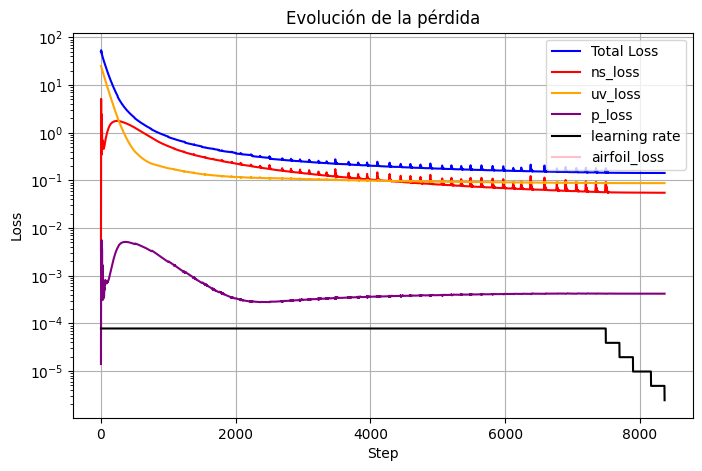

In [6]:
plt.figure(figsize=(8,5))
plt.semilogy(af_losses, label='Total Loss',color='blue')  # Usar semilogy para escala logarítmica en el eje y
plt.semilogy(af_ns_losses, label='ns_loss', color='red')
plt.semilogy(af_uv_losses, label='uv_loss', color='orange')
plt.semilogy(af_p_losses, label='p_loss', color='purple')
plt.semilogy(af_lr_list, label='learning rate', color='black')
plt.semilogy(airf_loss, label='airfoil_loss', color='pink')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.grid(True)
plt.show()

Saved Prediction Results Plot

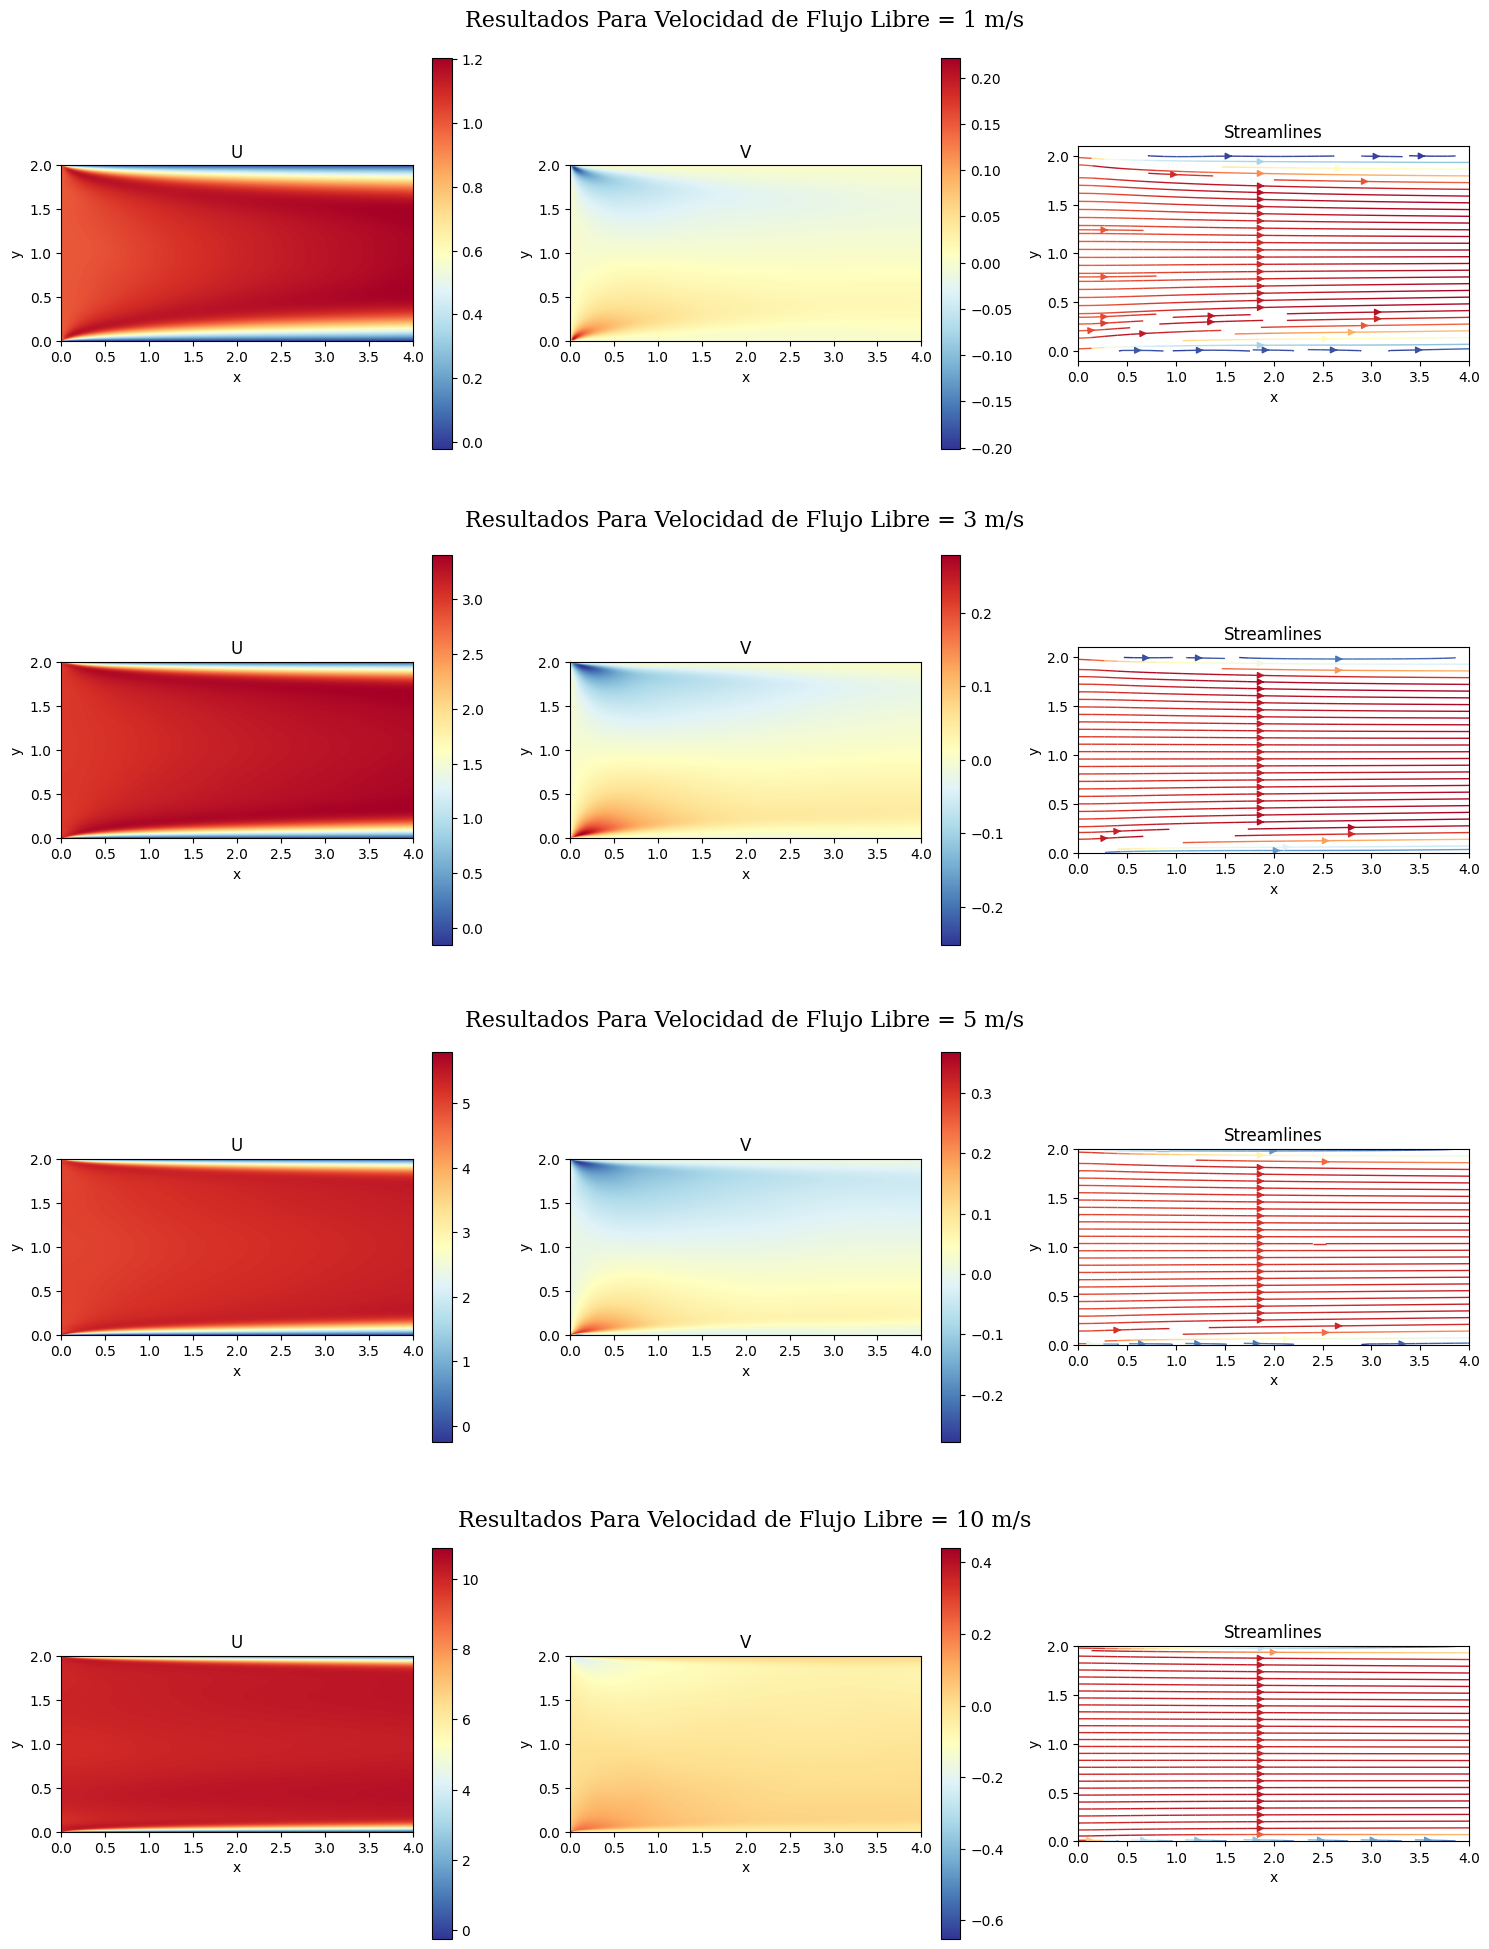

In [34]:
u_pred = {}
v_pred = {}
p_pred = {}

for idx, val in enumerate(Uinf_options):
    key = str(val)
    u_pred[key] = u_list[idx]
    v_pred[key] = v_list[idx]
    p_pred[key] = p_list[idx]

frames = len(Uinf_options)

fig, axes = plt.subplots(nrows=frames, ncols=3, figsize=(15, 5 * frames))

for i, U in enumerate(Uinf_options):
    key = str(U)
    u = u_pred[key]
    v = v_pred[key]
    p = p_pred[key]

    ax_u, ax_v, ax_p = axes[i]

    fig.text(0.5, 1.235 - (i + 1) / frames, f"Resultados Para Velocidad de Flujo Libre = {U} m/s", 
             ha='center', fontsize=16, fontname='Serif')

    # U
    im_u = ax_u.imshow(u, cmap='RdYlBu_r', origin='lower',
                       extent=[mesh[0].min(), mesh[0].max(), mesh[1].min(), mesh[1].max()])
    fig.colorbar(im_u, ax=ax_u, fraction=0.05)
    ax_u.set_title(f"U")
    ax_u.set_xlabel("x")
    ax_u.set_ylabel("y")

    # V
    im_v = ax_v.imshow(v, cmap='RdYlBu_r', origin='lower',
                       extent=[mesh[0].min(), mesh[0].max(), mesh[1].min(), mesh[1].max()])
    fig.colorbar(im_v, ax=ax_v, fraction=0.05)
    ax_v.set_title(f"V")
    ax_v.set_xlabel("x")
    ax_v.set_ylabel("y")

    # Streamlines
    strm = ax_p.streamplot(mesh[0], mesh[1], u, v, color=np.sqrt(u**2 + v**2), cmap='RdYlBu_r', linewidth=1)
    ax_p.set_aspect('equal')
    ax_p.set_title(f"Streamlines")
    ax_p.set_xlabel("x")
    ax_p.set_ylabel("y")

plt.tight_layout()
plt.show()